## Topic Modeling

### Project Description:

In the analysis below, the code seeks to cluster Toronto based restaurant reviews (2008 - 2019) to distinguish which are service or food-based. 

In undergoing the following analysis, the data processed can be leveraged to create a recommendation engine where the user can choose to be recommended restaurants by either all review types and ratings or the reviews that appear to be food-related based on the context of the reviews.

In [ ]:
# IMport packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 10)
import re, spacy, gensim
from pprint import pprint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
nltk.download('punkt')
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

### Data Preprocessing and Cleaning

In [114]:
# Import yelp data set
doc = pd.read_csv('Data/Yelp_Reviews_Data.csv')
doc = doc.drop(['Unnamed: 0'], axis = 1)

# Print data summary
print('\n')
doc.info()
doc.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225734 entries, 0 to 225733
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   name     225734 non-null  object 
 1   user_id  225734 non-null  object 
 2   text     225734 non-null  object 
 3   stars    225734 non-null  float64
dtypes: float64(1), object(3)
memory usage: 6.9+ MB


,name,user_id,text,stars
0,Levetto,TZQSUDDcA4ek5gBd6BzcjA,"In the heart of Chinatown, I discovered it enr...",4.0
1,Scaddabush Italian Kitchen & Bar,iFEM16O5BeKvf_AHs6NzUQ,Was super excited to bring my boyfriend to thi...,3.0
2,Patria,Eg_VTAQwK3CxYTORNRWd2g,"Excellent food, service and ambiance! The tapa...",5.0
3,The Fish Store & Sandwiches,Kl6jNDAE7PG_VVQafIptxQ,"Wow, this baby's got no love on Yelp since 201...",4.0
4,Mangia & Bevi,IeojscL3rg3x3vtmR-hWlA,"The pizza is very, very good! We arrived 15 mi...",4.0


The data set from the data preprocessing is imported above.

Further preprocessing will take place.

In [ ]:
# Clean text and convert to list of clean words
corpus = []
for x in range(0,len(doc['text'].tolist())):
    # Remove all but necessary text
    review = re.sub('[^a-zA-Z]',' ',doc['text'][x])
    # convert all text to lower case
    review = review.lower()
    # Split all words into individual instances
    review = review.split()
    # Retain only the root words of the text
    ps = PorterStemmer()
    # Remove stop words
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    # Remove all commas and split the text by spaces per review
    review = ' '.join(review) 
    # append all reviews to the corpus list
    corpus.append(review)
    
# Convert corpus list to data frame and export corpus data frame to project directory
corpus = pd.DataFrame(corpus, columns = ['new_text']).reset_index()
corpus.to_csv('Data/Cleaned_Corpus.csv')

The reviews text is cleaned and exported as a data set to avoid having to undergo the text cleaning process again.

In [115]:
# Import cleaned corpus data set
new_text = pd.read_csv('Data/Cleaned_Corpus.csv')
new_text = new_text.drop(['Unnamed: 0'], axis = 1)

# Print data summary
print('\n')
new_text.info()
new_text.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225734 entries, 0 to 225733
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     225734 non-null  int64 
 1   new_text  225660 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,index,new_text
0,0,heart chinatown discov enrout kensington marke...
1,1,super excit bring boyfriend scaddabush locat g...
2,2,excel food servic ambianc tapa truli infus spa...
3,3,wow babi got love yelp sinc well guy miss yum ...
4,4,pizza good arriv minut close time restaur staf...


The data set exported previously is imported back into the notebook to continue analysis.

In [116]:
# Check for na vlaues
na = new_text.loc[new_text['new_text'].isna()]
print(len(new_text.loc[new_text['new_text'].isna()]))

# Print data summary
print('\n')
na.info()
na.head()

74


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1937 to 223366
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     74 non-null     int64 
 1   new_text  0 non-null      object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


,index,new_text
1937,1937,NaN
14194,14194,NaN
17732,17732,NaN
19260,19260,NaN
20601,20601,NaN


There are 74 na values in the data set.

In [117]:
# View na values
na_index = na['index'].tolist()
doc = doc.reset_index(drop = True).reset_index()
na_text = doc[doc['index'].isin(na_index)]

# Print data summary
print('\n')
na_text.info()
na_text



<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1937 to 223366
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    74 non-null     int64  
 1   name     74 non-null     object 
 2   user_id  74 non-null     object 
 3   text     74 non-null     object 
 4   stars    74 non-null     float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.5+ KB


,index,name,user_id,text,stars
1937,1937,Jimmy's Coffee,z9w399cBpCAKXhH_JA1AtQ,某微信公众号看到有推荐呢间咖啡店的黑炭咖啡唔错，且分店都几就脚。午餐后就看住导航去探店啦。门...,4.0
14194,14194,Red Lobster,l1oOIK6syB4pojHs-MrPtw,シェラトンセンターから歩いて行けるロブスター屋を探したら、ここが出てきた。ロブスターやサーモ...,3.0
17732,17732,Ramen Isshin,6J_HcyASbyoawPUSRggsZw,店内の雰囲気は落ち着いていて、清潔感がある。メニューは日本語でも書いてあるので迷わず注文でき...,4.0
19260,19260,Sud Forno,7f_8O9azJn4_LKVdFbyRfQ,トロントに来て1週間目。有名な日本食スーパーからの帰りに立ち寄る。\n\n居心地が良い。\n...,5.0
20601,20601,Ramen Isshin,BlaFf4zkxhaTjjZ194L5Ag,久しぶりに海外で本物のラーメンに出会った。\n好物のトンコツが無かったのは寂しいが、しょうゆ...,5.0
24429,24429,Rol San,rpHdyykul05KqPBCJpzdMA,服務很差！ 明明我們四個人號碼牌比較前面 後面好幾組的五個人都比我們早入座！ 服務生食物也用...,1.0
25751,25751,Kimchi Korea House,pB56guA8eooYUmvQhiy66A,通常のビビンバを頂いた。\nワカメサラダ、ビールで約25ドル。\nコスパ的には評価2かな？\...,3.0
26160,26160,New Sky Restaurant,X-uefJdU44ctKNdB80qqAQ,我們一大群人聚會之後就來到這餐廳享用晚餐。中國菜一大群人一起吃的話來講價錢不算貴，但是因為我...,3.0
26923,26923,Rol San,FO-WF4ixw6QNGi_0QWRfAg,超級差的服務，從沒吃過這麼糟糕的餐廳，它的食物沒有好吃到可以把服務人員的差給彌補過去，而且上...,1.0
28456,28456,Kasa Moto,q9DapSEhthPiAxPA565KjA,第一次次試熱石頭烤和牛，入口即化非常好吃，蔥蒜醬料也好吃，這裡服務品質也很好\n即便我一個人...,5.0


The na values are further observed and show that they are in a language other than English and/or blank values due to stop word removal.

In [118]:
# Merge the two data sets
doc = doc.merge(new_text, on = 'index')
doc = doc.drop(['index'], axis = 1)
# Drop na values
doc = doc.dropna()
# Rename columns
doc.columns = ['business_name','user_id','old_text','stars','new_text']

# Print data summary
print('\n')
doc.info()
doc.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 225660 entries, 0 to 225733
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   business_name  225660 non-null  object 
 1   user_id        225660 non-null  object 
 2   old_text       225660 non-null  object 
 3   stars          225660 non-null  float64
 4   new_text       225660 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.3+ MB


,business_name,user_id,old_text,stars,new_text
0,Levetto,TZQSUDDcA4ek5gBd6BzcjA,"In the heart of Chinatown, I discovered it enr...",4.0,heart chinatown discov enrout kensington marke...
1,Scaddabush Italian Kitchen & Bar,iFEM16O5BeKvf_AHs6NzUQ,Was super excited to bring my boyfriend to thi...,3.0,super excit bring boyfriend scaddabush locat g...
2,Patria,Eg_VTAQwK3CxYTORNRWd2g,"Excellent food, service and ambiance! The tapa...",5.0,excel food servic ambianc tapa truli infus spa...
3,The Fish Store & Sandwiches,Kl6jNDAE7PG_VVQafIptxQ,"Wow, this baby's got no love on Yelp since 201...",4.0,wow babi got love yelp sinc well guy miss yum ...
4,Mangia & Bevi,IeojscL3rg3x3vtmR-hWlA,"The pizza is very, very good! We arrived 15 mi...",4.0,pizza good arriv minut close time restaur staf...


The na values are removed from the data set.

In [119]:
# Show simple descriptive stats
print('\n' + 'number of businesses: ' + str(len(doc['business_name'].unique())))
print('\n' + 'number of users: ' + str(len(doc['user_id'].unique())))
print('\n' + 'number of reviews: ' + str(doc['old_text'].count()) + '\n')


number of businesses: 911

number of users: 68917

number of reviews: 225660



### Model Creation

In [10]:
# Set each review in cleaned text to a list
corpus = doc['new_text'].tolist()
# vectorize each word in the corpus list by count per review 
vectorizer = CountVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(corpus)

In [ ]:
# Generate the latent dirichlet allocation algorithm
lda_model = LatentDirichletAllocation(n_components = 4, max_iter = 100, random_state = 0, verbose = 1, n_jobs = -1)
# Fit the count vector matrix to the lda algorithm
lda_model.fit(X)

A count of all words per review matrix is fit to a Latent Dirichlet Allocation (LDA) model.

After filtering through many n_components, 4 seemed to split the service from the food reviews that best.

For strong results the iterations are set to 100.

### Model Results and EDA

In [19]:
# Log Likelyhood
print("Log Likelihood: ", lda_model.score(X))

# Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -90069437.25762974
Perplexity:  1465.9901830442943
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 100,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 1}


In [12]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(X)

# Column names
topicnames = ["topic" + str(i) for i in range(lda_model.n_components)]

# Index names
docnames = ["doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topicnames, index = docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis = 1)
df_document_topic['dominant_topic1'] = dominant_topic
df_document_topic['dominant_topic1'] = df_document_topic['dominant_topic1'].astype(str)
df_document_topic['topic'] = "topic"
df_document_topic['dominant_topic'] = df_document_topic['topic'] + df_document_topic['dominant_topic1']
df_document_topic = df_document_topic.drop(['dominant_topic1', 'topic'], axis = 1)

# Export data to project drirectory
df_document_topic.to_csv('Data/Dom_Topics.csv')

In [4]:
# Import topic percentage per review data frame
df_document_topic = pd.read_csv('Data/Dom_Topics.csv')
df_document_topic = df_document_topic.drop(['Unnamed: 0'], axis = 1)

# Print data summary 
print('\n')
df_document_topic.info()
df_document_topic.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225660 entries, 0 to 225659
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   topic0          225660 non-null  float64
 1   topic1          225660 non-null  float64
 2   topic2          225660 non-null  float64
 3   topic3          225660 non-null  float64
 4   dominant_topic  225660 non-null  object 
dtypes: float64(4), object(1)
memory usage: 8.6+ MB


,topic0,topic1,topic2,topic3,dominant_topic
0,0.30,0.29,0.00,0.41,topic3
1,0.66,0.00,0.00,0.33,topic0
2,0.01,0.01,0.56,0.43,topic2
3,0.01,0.12,0.87,0.01,topic2
4,0.79,0.03,0.03,0.16,topic0


A data set with the percentage of all topics per review with the dominant topic label.

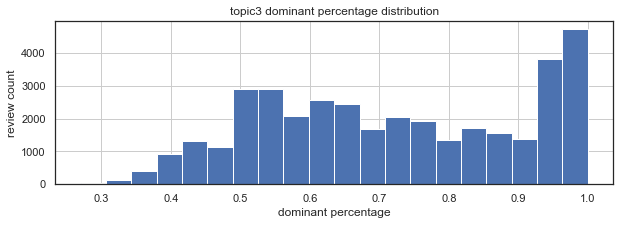

total number of topic3reviews: 37131
number of reviews with topic3 >= 50% (0.5): 24773
percent of topic3 that's >= 50% (0.5) per review: 0.67


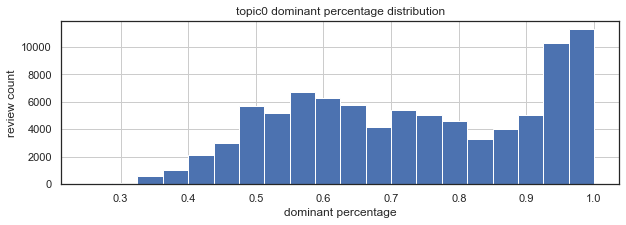

total number of topic0reviews: 89594
number of reviews with topic0 >= 50% (0.5): 61550
percent of topic0 that's >= 50% (0.5) per review: 0.69


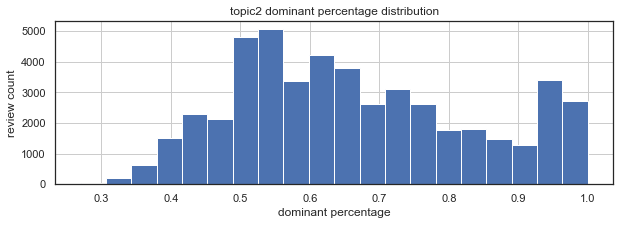

total number of topic2reviews: 48887
number of reviews with topic2 >= 50% (0.5): 29145
percent of topic2 that's >= 50% (0.5) per review: 0.6


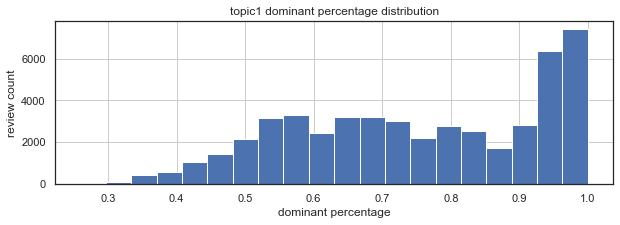

total number of topic1reviews: 50048
number of reviews with topic1 >= 50% (0.5): 35729
percent of topic1 that's >= 50% (0.5) per review: 0.71


In [38]:
# List of unique topics
dom_topic = df_document_topic['dominant_topic'].unique()

# Get distribution of dominant topic percentages per review and descriptive stats 
# including dominant topics over 50% per riview as a percantage of all reviews
for topic in dom_topic:
    dom_topic = df_document_topic.loc[df_document_topic['dominant_topic'] == topic]
    sns.set(font_scale = 1, style = 'white')
    dom_topic[topic].hist(bins = 20, figsize = (10, 3))
    plt.title(topic + ' dominant percentage distribution')
    plt.xlabel('dominant percentage')
    plt.ylabel('review count')
    plt.show()
    total_reviews = len(dom_topic[topic])
    p50 = df_document_topic.loc[df_document_topic[topic] >= 0.5]
    p50 = int(round(p50[topic].sum(),0))
    plus50 = round(p50/total_reviews,2)
    print('total number of ' + topic + 'reviews: ' + str(total_reviews))
    print('number of reviews with ' + topic + ' >= 50% (0.5): ' + str(p50))
    print('percent of ' + topic + " that's >= 50% (0.5) per review: " + str(plus50))

The quality of the topics is analyzed by observing the distributions of the topic percentage for each review the topic is assigned to. 

All four topics appear to represent large proportions of their assigned to reviews, demonstrating the quality of the topics.

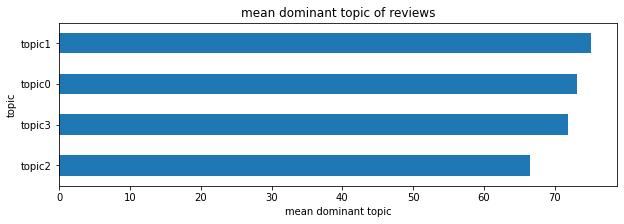

        means
topic        
topic1  75.02
topic0  73.12
topic3  71.85
topic2  66.42


In [21]:
# Get the mean dominant topic percentage for each topic for all reviews
index = []
mean_val = []
for topic in dom_topic:
    df = df_document_topic.loc[df_document_topic['dominant_topic'] == topic]
    df = df[[topic]]
    mean = round(df[topic].mean() * 100, 2)
    index.append(topic)
    mean_val.append(mean)

# Visualize the mean dominant topic percentage for each topic for all reviews
topic_means = pd.DataFrame(mean_val, index = index, columns = ['means']).reset_index()
topic_means.columns = ['topic', 'means']
topic_means = topic_means.sort_values(by = ['means'], ascending = True)
topic_means.plot.barh(x = 'topic', y = 'means', figsize = (10, 3), legend = None)
plt.title('mean dominant topic of reviews')
plt.xlabel('mean dominant topic')
plt.ylabel('topic')
plt.show()
topic_means = topic_means.sort_values(by = ['means'], ascending = False)
topic_means = topic_means.set_index('topic')
print(topic_means)

The topics' mean percentage of all assigned to reviews are visualized and return strong results.

All topics have a presence greater than or equal to 66% in their assigned reviews.

In [16]:
# Observing topic words (tokens), word freqencies per topic, and topic similarity (cluster distance)
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds = 'tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  38.965268
2        1.782994 -295.079681       2        1  23.470184
1      220.811432 -343.832123       3        1  19.648322
3       50.533993  -76.050934       4        1  17.916226, topic_info=             Term           Freq          Total Category  logprob  loglift
22189         fri   51068.000000   51068.000000  Default  30.0000  30.0000
10785     chicken   51495.000000   51495.000000  Default  29.0000  29.0000
13636       cream   24689.000000   24689.000000  Default  28.0000  28.0000
44320       pizza   24115.000000   24115.000000  Default  27.0000  27.0000
28020         ice   23625.000000   23625.000000  Default  26.0000  26.0000
21567        food  173458.000000  173458.000000  Default  25.0000  25.0000
8243       burger   26227.000000   26227.000000  Default  24.0000  24.0000
39876       noodl   23353.000000   23353.000000  Default  23.0000  23.0000
47057       ramen   21324.000000   21324.000000  Default  22.0000  22.0000
12075       coffe   18328.000000   18328.000000  Default  21.0000  21.0000
56568       sushi   21093.000000   21093.000000  Default  20.0000  20.0000
56982        taco   18621.000000   18621.000000  Default  19.0000  19.0000
16378        dish   54806.000000   54806.000000  Default  18.0000  18.0000
45020        pork   26855.000000   26855.000000  Default  17.0000  17.0000
54299        soup   24225.000000   24225.000000  Default  16.0000  16.0000
48723        rice   25573.000000   25573.000000  Default  15.0000  15.0000
58252        thai   16107.000000   16107.000000  Default  14.0000  14.0000
8776         cake   16422.000000   16422.000000  Default  13.0000  13.0000
50522        sauc   39853.000000   39853.000000  Default  12.0000  12.0000
10542       chees   26274.000000   26274.000000  Default  11.0000  11.0000
57718         tea   18255.000000   18255.000000  Default  10.0000  10.0000
11085      chocol   13084.000000   13084.000000  Default   9.0000   9.0000
36119        meat   26180.000000   26180.000000  Default   8.0000   8.0000
54660       spici   21730.000000   21730.000000  Default   7.0000   7.0000
21222     flavour   38695.000000   38695.000000  Default   6.0000   6.0000
49971       salad   28177.000000   28177.000000  Default   5.0000   5.0000
5130         beef   24159.000000   24159.000000  Default   4.0000   4.0000
18117         egg   19576.000000   19576.000000  Default   3.0000   3.0000
15691     dessert   25207.000000   25207.000000  Default   2.0000   2.0000
57509        tast   60485.000000   60485.000000  Default   1.0000   1.0000
35135       manag    9816.020727    9816.812324   Topic1  -6.1953   0.9424
38513       music    7589.605073    7590.401792   Topic1  -6.4525   0.9424
22903        game    5928.727718    5929.507327   Topic1  -6.6995   0.9424
49595        rude    4882.883290    4883.648883   Topic1  -6.8936   0.9423
46192         pub    4386.683249    4387.460494   Topic1  -7.0007   0.9423
27476     hostess    4349.047030    4349.825448   Topic1  -7.0093   0.9423
4671      bartend    3705.297229    3706.067891   Topic1  -7.1695   0.9423
25219       guest    3015.957350    3016.752331   Topic1  -7.3754   0.9422
2491       apolog    2813.941032    2814.711344   Topic1  -7.4447   0.9422
3459      attitud    2762.440239    2763.210755   Topic1  -7.4632   0.9422
57357         tap    2584.154154    2584.939543   Topic1  -7.5299   0.9422
27468        host    2420.734954    2421.524200   Topic1  -7.5952   0.9422
2232        annoy    2442.515746    2443.312982   Topic1  -7.5863   0.9422
28167       ignor    1876.027028    1876.806244   Topic1  -7.8501   0.9421
54830       sport    1812.653478    1813.420806   Topic1  -7.8845   0.9421
60556          tv    1761.138221    1761.920308   Topic1  -7.9133   0.9421
65673        yell    1568.007291    1568.793069   Topic1  -8.0295   0.9420
21290    

**Note -** The visualization displays topics starting from 1 as apposed to 0.

The visualization can be interacted with by hovering over the circles for the frequencies of words each topic represents regarding the whole data set by the size of the circles.

Toggling the relevance slider. 0 shows the top 30 words per topic specific to that topic while 1 shows the top 30 words in that topic but may exist in other topics. Toggling to values in between 0 - 1 adjust accordingly.

The distance between the topics shows how different the topics are justifying the topic assignments.

**Topic context:**

* **Topic 1** - Service
* **Topic 2** - Food
* **Topic 3** - Food
* **Topic 4** - Food

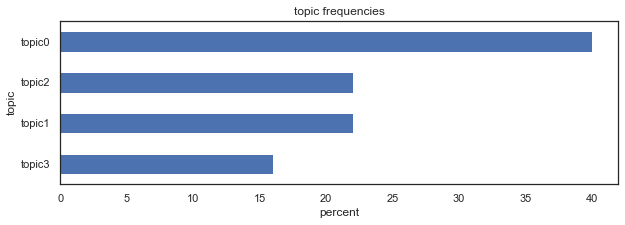

        doc_%_freq
topic0        40.0
topic2        22.0
topic1        22.0
topic3        16.0


In [15]:
# Topic frequencies visualization
series = df_document_topic['dominant_topic'].reset_index(name = 'num_documents')
series.columns = ['topic_num', 'num_documents']
series = series['num_documents']
series = round((series.value_counts() / len(series)) * 100, 0)
series = series.sort_values(ascending = True)
sns.set(font_scale = 1, style = 'white')
series.plot.barh(figsize = (10, 3))
plt.title('topic frequencies')
plt.xlabel('percent')
plt.ylabel('topic')
plt.show()
series = series.sort_values(ascending = False)
df = series.to_frame()
df.columns = ['doc_%_freq']
print(df)

The bar plot shows the frequencies of each topic in the data set expressed as a percentage.

In [20]:
# Merge topic labels with the original data set
doc['topic'] = lda_output.argmax(axis = 1)

# Print data summary 
print('\n')
doc.info()
doc.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 225660 entries, 0 to 225733
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   business_name  225660 non-null  object 
 1   user_id        225660 non-null  object 
 2   old_text       225660 non-null  object 
 3   stars          225660 non-null  float64
 4   new_text       225660 non-null  object 
 5   topic          225660 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 12.1+ MB


,business_name,user_id,old_text,stars,new_text,topic
0,Levetto,TZQSUDDcA4ek5gBd6BzcjA,"In the heart of Chinatown, I discovered it enr...",4.0,heart chinatown discov enrout kensington marke...,3
1,Scaddabush Italian Kitchen & Bar,iFEM16O5BeKvf_AHs6NzUQ,Was super excited to bring my boyfriend to thi...,3.0,super excit bring boyfriend scaddabush locat g...,0
2,Patria,Eg_VTAQwK3CxYTORNRWd2g,"Excellent food, service and ambiance! The tapa...",5.0,excel food servic ambianc tapa truli infus spa...,2
3,The Fish Store & Sandwiches,Kl6jNDAE7PG_VVQafIptxQ,"Wow, this baby's got no love on Yelp since 201...",4.0,wow babi got love yelp sinc well guy miss yum ...,2
4,Mangia & Bevi,IeojscL3rg3x3vtmR-hWlA,"The pizza is very, very good! We arrived 15 mi...",4.0,pizza good arriv minut close time restaur staf...,0


In [21]:
# Export data set to project directory
doc.to_csv('Data/Finished_Reviews_Data.csv')

The topic labels are merged to the original data set and exported to the project directory.

In [97]:
# Import the data set with review topic labels
doc = pd.read_csv('Data/Finished_Reviews_Data.csv')
doc = doc.drop(['Unnamed: 0'], axis = 1)

# Print data summary 
print('\n')
doc.info()
doc.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225660 entries, 0 to 225659
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   business_name  225660 non-null  object 
 1   user_id        225660 non-null  object 
 2   old_text       225660 non-null  object 
 3   stars          225660 non-null  float64
 4   new_text       225660 non-null  object 
 5   topic          225660 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 10.3+ MB


,business_name,user_id,old_text,stars,new_text,topic
0,Levetto,TZQSUDDcA4ek5gBd6BzcjA,"In the heart of Chinatown, I discovered it enr...",4.0,heart chinatown discov enrout kensington marke...,3
1,Scaddabush Italian Kitchen & Bar,iFEM16O5BeKvf_AHs6NzUQ,Was super excited to bring my boyfriend to thi...,3.0,super excit bring boyfriend scaddabush locat g...,0
2,Patria,Eg_VTAQwK3CxYTORNRWd2g,"Excellent food, service and ambiance! The tapa...",5.0,excel food servic ambianc tapa truli infus spa...,2
3,The Fish Store & Sandwiches,Kl6jNDAE7PG_VVQafIptxQ,"Wow, this baby's got no love on Yelp since 201...",4.0,wow babi got love yelp sinc well guy miss yum ...,2
4,Mangia & Bevi,IeojscL3rg3x3vtmR-hWlA,"The pizza is very, very good! We arrived 15 mi...",4.0,pizza good arriv minut close time restaur staf...,0


The data set gets imported back into the notebook.

In [98]:
# Observe the unique user counts in the data set
user_count = doc['user_id'].value_counts()
user_count = pd.DataFrame(user_count).reset_index()
user_count.columns = ['user_id', 'user_counts']

print('user_counts:' + '\n')
print(user_count['user_counts'].describe())

# Print data summary 
print('\n')
user_count.info()
user_count.head()

user_counts:

count    68917.000000
mean         3.274374
std          7.866617
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        416.000000
Name: user_counts, dtype: float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68917 entries, 0 to 68916
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      68917 non-null  object
 1   user_counts  68917 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,user_id,user_counts
0,CxDOIDnH8gp9KXzpBHJYXw,416
1,Q9mA60HnY87C1TW5kjAZ6Q,230
2,O3pSxv1SyHpY4qi4Q16KzA,228
3,0BBUmH7Krcax1RZgbH4fSA,206
4,gwIqbXEXijQNgdESVc07hg,201


There are users in the data that only review and rate once, the threshold is 10 and these users will be removed from the data set.

In [99]:
# Observe the number of reviews per restaurant
rest_count = doc['business_name'].value_counts()
rest_count = pd.DataFrame(rest_count).reset_index()
rest_count.columns = ['business_name', 'business_counts']

print('restaurant_counts:' + '\n')
print(rest_count['business_counts'].describe())

# Print data summary 
print('\n')
rest_count.info()
rest_count.head()

restaurant_counts:

count     911.000000
mean      247.705818
std       207.789579
min       100.000000
25%       132.000000
50%       181.000000
75%       280.000000
max      2834.000000
Name: business_counts, dtype: float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    911 non-null    object
 1   business_counts  911 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


,business_name,business_counts
0,Pai Northern Thai Kitchen,2834
1,Banh Mi Boys,1733
2,KINKA IZAKAYA ORIGINAL,1618
3,Khao San Road,1603
4,Seven Lives Tacos Y Mariscos,1317


There are no restaurants present in the data set with less than 100 review which is perfect and no data will be removed regarding restaurant review frequencies.

In [100]:
# Merge user count to original data set
doc = doc.merge(user_count, on = 'user_id')

# Print data summary 
print('\n')
doc.info()
doc.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 225660 entries, 0 to 225659
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   business_name  225660 non-null  object 
 1   user_id        225660 non-null  object 
 2   old_text       225660 non-null  object 
 3   stars          225660 non-null  float64
 4   new_text       225660 non-null  object 
 5   topic          225660 non-null  int64  
 6   user_counts    225660 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.8+ MB


,business_name,user_id,old_text,stars,new_text,topic,user_counts
0,Levetto,TZQSUDDcA4ek5gBd6BzcjA,"In the heart of Chinatown, I discovered it enr...",4.0,heart chinatown discov enrout kensington marke...,3,35
1,Café La Gaffe,TZQSUDDcA4ek5gBd6BzcjA,One of my Baldwin Village favourites!\n\nIt's ...,5.0,one baldwin villag favourit well establish wel...,0,35
2,Niuda Hand-Pulled Noodles,TZQSUDDcA4ek5gBd6BzcjA,Great first experience.\n\nMy friend and I wer...,4.0,great first experi friend late dinner last wee...,1,35
3,Light Cafe,TZQSUDDcA4ek5gBd6BzcjA,Lots of new things to try on Baldwin this summ...,3.0,lot new thing tri baldwin summer includ new ki...,2,35
4,Raijin Ramen,TZQSUDDcA4ek5gBd6BzcjA,With the exponential growth of ramen joints in...,4.0,exponenti growth ramen joint citi one remain o...,1,35


In [101]:
# Keep all data with user counts >= 10
doc = doc.loc[doc['user_counts'] >= 10].reset_index(drop = True)

# Print data summary 
print('\n')
doc.info()
doc.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100763 entries, 0 to 100762
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   business_name  100763 non-null  object 
 1   user_id        100763 non-null  object 
 2   old_text       100763 non-null  object 
 3   stars          100763 non-null  float64
 4   new_text       100763 non-null  object 
 5   topic          100763 non-null  int64  
 6   user_counts    100763 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 5.4+ MB


,business_name,user_id,old_text,stars,new_text,topic,user_counts
0,Levetto,TZQSUDDcA4ek5gBd6BzcjA,"In the heart of Chinatown, I discovered it enr...",4.0,heart chinatown discov enrout kensington marke...,3,35
1,Café La Gaffe,TZQSUDDcA4ek5gBd6BzcjA,One of my Baldwin Village favourites!\n\nIt's ...,5.0,one baldwin villag favourit well establish wel...,0,35
2,Niuda Hand-Pulled Noodles,TZQSUDDcA4ek5gBd6BzcjA,Great first experience.\n\nMy friend and I wer...,4.0,great first experi friend late dinner last wee...,1,35
3,Light Cafe,TZQSUDDcA4ek5gBd6BzcjA,Lots of new things to try on Baldwin this summ...,3.0,lot new thing tri baldwin summer includ new ki...,2,35
4,Raijin Ramen,TZQSUDDcA4ek5gBd6BzcjA,With the exponential growth of ramen joints in...,4.0,exponenti growth ramen joint citi one remain o...,1,35


In [102]:
# Observe the new user counts
print('\n' + 'user counts:')
print(str(doc['user_counts'].describe()) + '\n')


user counts:
count    100763.000000
mean         45.596052
std          46.289387
min          10.000000
25%          17.000000
50%          30.000000
75%          57.000000
max         416.000000
Name: user_counts, dtype: float64



all users with less than 10 reviews and ratings are removed form the data set leaving a data set with total reviews of 100,763.

In [103]:
# Observe the frequencies of important features
print('\n' + 'number of businesses: ' + str(len(doc['business_name'].unique())))
print('\n' + 'number of users: ' + str(len(doc['user_id'].unique())))
print('\n' + 'number of reviews: ' + str(doc['old_text'].count()) + '\n')


number of businesses: 911

number of users: 4045

number of reviews: 100763



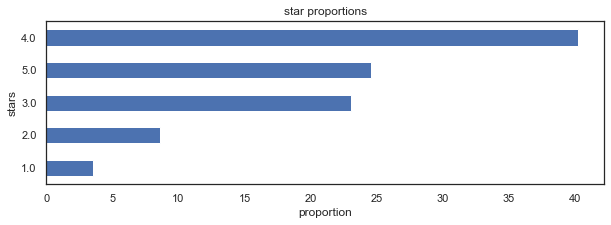



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 4 to 0
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stars        5 non-null      float64
 1   star_counts  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0 bytes


,stars,star_counts
4,1.0,3.55
3,2.0,8.65
2,3.0,23.02
1,5.0,24.60
0,4.0,40.18


In [79]:
# Observe star rating frequencies
star_count = round((doc['stars'].value_counts() / len(doc['stars'])) * 100, 2)
star_count = pd.DataFrame(star_count).reset_index()
star_count.columns = ['stars', 'star_counts']
star_count = star_count.sort_values(by = ['star_counts'], ascending = True)
star_count.plot.barh(x = 'stars', y = 'star_counts', figsize = (10, 3), legend = None)
plt.title('star proportions')
plt.xlabel('proportion')
plt.ylabel('stars')
plt.show()

# Print data summary 
print('\n')
star_count.info()
star_count.head()

The restaurant ratings seem to show that the majority of reviews are above two and most have a positive sentiment. 

In [47]:
# Export data set to project directory
doc = doc.drop(['user_counts'], axis = 1)
doc.to_csv('Data/Preprocessed_Reviews_Data.csv')